In [2]:
import cv2
import numpy as np
import os
from IPython.display import Image, display
import matplotlib.pyplot as plt

In [ ]:
# Task 1
# declare a video capture object
vid = cv2.VideoCapture(0)

captured_frame = None 

while True:
    # Capture the video frame by frame
    ret, frame_raw = vid.read()
    if not ret:
        break

    frame = cv2.flip(frame_raw, 1)
    print(frame.shape) 


    # Display the resulting frame
    cv2.imshow('COMP4423 A1', frame)

    if captured_frame is not None:
        cv2.imshow('Task 1: Captured Image', captured_frame)

    key = cv2.waitKey(1) & 0xFF

    #-------------------Press 'q' to quit------------------------
    if key == ord('q'):
        break

    # ------------------Press 'c' to capture image------------------
    if key == ord('c') and captured_frame is None:
        captured_frame = frame.copy()
        cv2.imwrite('captured_image.png', captured_frame)
        print('Image captured.')

# release the cap object
vid.release()
cv2.destroyAllWindows()

# display the captured image
if os.path.exists('captured_image.png'):
    display(Image('captured_image.png'))


(100, 100)


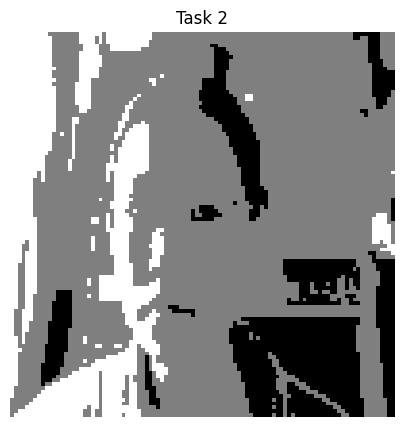

In [5]:
# Task 2
# load the captured image
captured_frame = cv2.imread('captured_image.png')

# 1. the generated image should be no more than 100x100
img_size = (100, 100)
img_resized = cv2.resize(captured_frame, img_size, interpolation=cv2.INTER_AREA)

# 2. convert the image to grayscale
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

# 3. three colors in the bricks (e.g., white, gray, black)
img_color = np.zeros_like(img_gray)
# black
img_color[img_gray <= 85] = 0 
# gray
img_color[(img_gray > 85) & (img_gray <= 170)] = 127
# white
img_color[img_gray > 170] = 255    
'''
# improve: upscale for display so it doesn't look tiny
scale = 6  # 100x100 -> 600x600
img_lego_display = cv2.resize(
    img_color,
    (img_size[0]*scale, img_size[1]*scale),
    interpolation=cv2.INTER_NEAREST
)
'''

# show results
print(img_color.shape) 

cv2.imshow('Task 2: LEGO Image (100x100, 3 colors)', img_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

# display
plt.figure(figsize=(5, 5))
plt.imshow(img_color, cmap='gray', vmin=0, vmax=255)
plt.title('Task 2')
plt.axis('off')
plt.show()

Grid size: 100x100
Total bricks: 2929
Brick counts (height x width):
  1x1: 394
  1x2: 249
  1x4: 78
  2x1: 1536
  2x2: 175
  2x4: 39
  4x2: 327
  4x4: 131


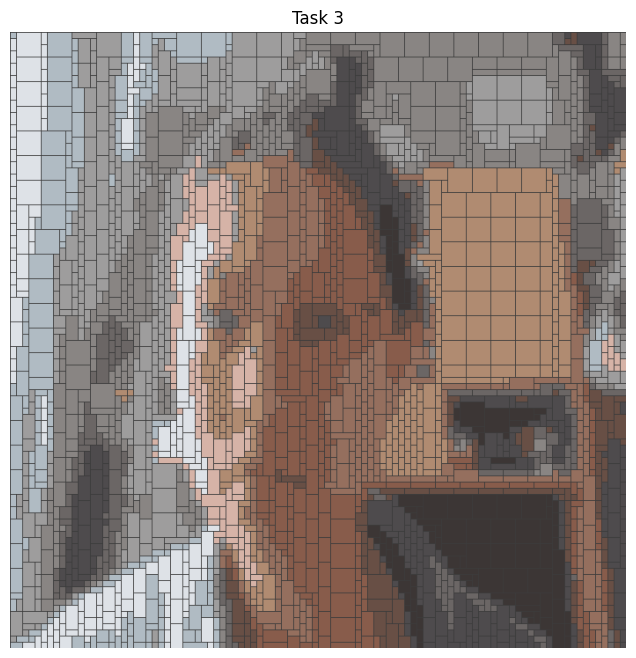

In [ ]:
# Task 3

h,w,_ = img_resized.shape
print(f"Grid size: {h}x{w}")

# 1. add more colors
# let k as number of colors
K = 12
img_blur = cv2.GaussianBlur(img_resized, (3, 3), 0)
Z = img_blur.reshape((-1, 3)).astype(np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

_, labels, centers = cv2.kmeans(Z, K, None, criteria, 5, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
labels = labels.reshape((h, w))

# 2. brick size, largest first
brick_types = [
    (4, 4),
    (4, 2),
    (2, 4),
    (2, 2),
    (1, 4),
    (1, 2),
    (2, 1),
    (1, 1),
]

used = np.zeros((h, w), dtype=bool)
bricks = []     
brick_counts = {}

for r in range(h):
    for c in range(w):
        if used[r, c]:
            continue

        color_idx = labels[r, c]
        placed = False

        for bh, bw in brick_types:
            if r + bh > h or c + bw > w:
                continue

            region_labels = labels[r:r+bh, c:c+bw]
            region_used = used[r:r+bh, c:c+bw]

            if np.all(region_labels == color_idx) and not np.any(region_used):
                used[r:r+bh, c:c+bw] = True
                bricks.append((r, c, bh, bw, color_idx))
                brick_counts[(bh, bw)] = brick_counts.get((bh, bw), 0) + 1
                placed = True
                break

        if not placed:
            used[r, c] = True
            bricks.append((r, c, 1, 1, color_idx))
            brick_counts[(1, 1)] = brick_counts.get((1, 1), 0) + 1

# 2. render the LEGO image with bricks
stud_px = 8  # pixels per stud
render_h, render_w = h * stud_px, w * stud_px
lego_render = np.zeros((render_h, render_w, 3), dtype=np.uint8)

for r, c, bh, bw, color_idx in bricks:
    color = centers[color_idx].tolist()
    top, left = r * stud_px, c * stud_px
    bottom, right = (r + bh) * stud_px, (c + bw) * stud_px
    # fill brick
    cv2.rectangle(lego_render, (left, top), (right, bottom), color, thickness=-1)
    # border
    border_color = (60, 60, 60) 
    cv2.rectangle(lego_render, (left, top), (right, bottom), border_color, thickness=1)


cv2.imshow('Task 3: LEGO multi-size, multi-color', lego_render)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 3, summary
total_bricks = sum(brick_counts.values())
print("Total bricks:", total_bricks)
print("Brick counts (height x width):")
for (bh, bw), cnt in sorted(brick_counts.items()):
    print(f"  {bh}x{bw}: {cnt}")

# display in notebook output
lego_render_rgb = cv2.cvtColor(lego_render, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(lego_render_rgb)
plt.title('Task 3')
plt.axis('off')
plt.show()


In [ ]:
# Task 4

# generate LEGO style image from a frame
def generate_lego_image(frame, max_size=(100, 100), K=12):
    # resize to 100x100
    img_resized = cv2.resize(frame, max_size, interpolation=cv2.INTER_AREA)
    h, w, _ = img_resized.shape

    # k-means color quantization to K colors
    img_blur = cv2.GaussianBlur(img_resized, (3, 3), 0)
    Z = img_blur.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, K, None, criteria, 5, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    labels = labels.reshape((h, w))

    # greedy tiling with different brick sizes
    brick_types = [
    (4, 4),
    (4, 2),
    (2, 4),
    (2, 2),
    (1, 4),
    (1, 2),
    (2, 1),
    (1, 1),
]

    used = np.zeros((h, w), dtype=bool)
    bricks = []

    for r in range(h):
        for c in range(w):
            if used[r, c]:
                continue

            color_idx = labels[r, c]
            placed = False

            for bh, bw in brick_types:
                if r + bh > h or c + bw > w:
                    continue

                region_labels = labels[r:r+bh, c:c+bw]
                region_used = used[r:r+bh, c:c+bw]

                if np.all(region_labels == color_idx) and not np.any(region_used):
                    used[r:r+bh, c:c+bw] = True
                    bricks.append((r, c, bh, bw, color_idx))
                    placed = True
                    break

            if not placed:
                used[r, c] = True
                bricks.append((r, c, 1, 1, color_idx))

    # render LEGO-style image
    stud_px = 6  
    render_h, render_w = h * stud_px, w * stud_px
    lego_render = np.zeros((render_h, render_w, 3), dtype=np.uint8)

    for r, c, bh, bw, color_idx in bricks:
        color = centers[color_idx].tolist()
        top, left = r * stud_px, c * stud_px
        bottom, right = (r + bh) * stud_px, (c + bw) * stud_px
        cv2.rectangle(lego_render, (left, top), (right, bottom), color, thickness=-1)
        border_color = (60, 60, 60)
        cv2.rectangle(lego_render, (left, top), (right, bottom), border_color, thickness=1)

    return lego_render


# real time
vid = cv2.VideoCapture(0)

lego_window_open = False

print("Press 'b' to generate LEGO-style image from current frame.")
print("Press 'q' to quit.")

while True:
    ret, frame_raw = vid.read()
    if not ret:
        break

    frame = cv2.flip(frame_raw, 1)  
    cv2.imshow('Task 4: Live Camera (Original)', frame)

    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break

    # ------------------------Press 'b' to generate and display LEGO-style image--------------------------
    if key == ord('b'):
        lego_img = generate_lego_image(frame)
        cv2.imshow('Task 4', lego_img)
        lego_window_open = True

vid.release()
cv2.destroyAllWindows()


Press 'b' to generate LEGO-style image from current frame.
Press 'q' to quit.
